In [2]:
# -*- coding: utf-8 -*-
import glob
# import seaborn as sns
import logging
import logging.handlers
import os
import platform
import sys
import argparse
import traceback
import warnings
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import xarray as xr
from scipy.stats import linregress
import pandas as pd
import cartopy.crs as ccrs
import math
from scipy import spatial
from pandas.tseries.offsets import Day, Hour, Minute, Second
from scipy.interpolate import Rbf
from numpy import zeros, newaxis

# os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share"
# from pygem import IDW
import eccodes
import pygrib
# import pykrige.kriging_tools as kt
import haversine as hs
import pytz
import pvlib
import pandas as pd

# from auto_ts import auto_timeseries
# from plotnine import ggplot
# from pycaret.regression import setup
# from pycaret.regression import compare_models
# from pycaret.regression import *

# =================================================
# 사용자 매뉴얼
# =================================================
# [소스 코드의 실행 순서]
# 1. 초기 설정 : 폰트 설정
# 2. 유틸리티 함수 : 초기화 함수 (로그 설정, 초기 변수, 초기 전달인자 설정) 또는 자주 사용하는 함수
# 3. 주 프로그램 :부 프로그램을 호출
# 4. 부 프로그램 : 자료 처리를 위한 클래스로서 내부 함수 (초기 변수, 비즈니스 로직, 수행 프로그램 설정)
# 4.1. 환경 변수 설정 (로그 설정) : 로그 기록을 위한 설정 정보 읽기
# 4.2. 환경 변수 설정 (초기 변수) : 입력 경로 (inpPath) 및 출력 경로 (outPath) 등을 설정
# 4.3. 초기 변수 (Argument, Option) 설정 : 파이썬 실행 시 전달인자 설정 (pyhton3 *.py argv1 argv2 argv3 ...)
# 4.4. 비즈니스 로직 수행 : 단위 시스템 (unit 파일명)으로 관리 또는 비즈니스 로직 구현

# =================================================
# 1. 초기 설정
# =================================================
warnings.filterwarnings("ignore")

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# sns.set(font="Malgun Gothic", rc={"axes.unicode_minus": False}, style='darkgrid')

# 그래프에서 마이너스 글꼴 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 타임존 설정
tzKst = pytz.timezone('Asia/Seoul')
tzUtc = pytz.timezone('UTC')


# =================================================
# 2. 유틸리티 함수
# =================================================
# 로그 설정
def initLog(env=None, contextPath=None, prjName=None):
    if env is None: env = 'local'
    if contextPath is None: contextPath = os.getcwd()
    if prjName is None: prjName = 'test'

    saveLogFile = "{}/{}_{}_{}_{}.log".format(
        contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'log', prjName)
        , platform.system()
        , platform.node()
        , prjName
        , datetime.now().strftime("%Y%m%d")
    )

    if not os.path.exists(os.path.dirname(saveLogFile)):
        os.makedirs(os.path.dirname(saveLogFile))

    # logger instance 생성
    log = logging.getLogger(prjName)

    if len(log.handlers) > 0:
        return log

    # format 생성
    format = logging.Formatter('%(asctime)s [%(name)s | %(lineno)d | %(filename)s] [%(levelname)-5.5s] %(message)s')

    # handler 생성
    streamHandler = logging.StreamHandler()
    fileHandler = logging.FileHandler(saveLogFile)

    # logger instance에 format 설정
    streamHandler.setFormatter(format)
    fileHandler.setFormatter(format)

    # logger instance에 handler 설정
    log.addHandler(streamHandler)
    log.addHandler(fileHandler)

    # logger instance로 log 기록
    log.setLevel(level=logging.INFO)

    return log


#  초기 변수 설정
def initGlobalVar(env=None, contextPath=None, prjName=None):
    if env is None: env = 'local'
    if contextPath is None: contextPath = os.getcwd()
    if prjName is None: prjName = 'test'

    # 환경 변수 (local, 그 외)에 따라 전역 변수 (입력 자료, 출력 자료 등)를 동적으로 설정
    # 즉 local의 경우 현재 작업 경로 (contextPath)를 기준으로 설정
    # 그 외의 경우 contextPath/resources/input/prjName와 같은 동적으로 구성
    globalVar = {
        'prjName': prjName
        , 'sysOs': platform.system()
        , 'contextPath': contextPath
        , 'resPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources')
        , 'cfgPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'config')
        , 'inpPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'input', prjName)
        , 'figPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'fig', prjName)
        , 'outPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'output', prjName)
        , 'movPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'movie', prjName)
        , 'logPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'log', prjName)
        , 'mapPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'mapInfo')
        , 'sysPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'config', 'system.cfg')
        ,
        'seleniumPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'config', 'selenium')
        , 'fontPath': contextPath if env in 'local' else os.path.join(contextPath, 'resources', 'config', 'fontInfo')
    }

    return globalVar


#  초기 전달인자 설정
def initArgument(globalVar, inParams):
    # 원도우 또는 맥 환경
    if globalVar['sysOs'] in 'Windows' or globalVar['sysOs'] in 'Darwin':
        inParInfo = inParams

    # 리눅스 환경
    if globalVar['sysOs'] in 'Linux':
        parser = argparse.ArgumentParser()

        for i, argv in enumerate(sys.argv[1:]):
            if not argv.__contains__('--'): continue
            parser.add_argument(argv)

        inParInfo = vars(parser.parse_args())

    log.info("[CHECK] inParInfo : {}".format(inParInfo))

    for key, val in inParInfo.items():
        if val is None: continue
        # 전역 변수에 할당
        globalVar[key] = val

    # 전역 변수
    for key, val in globalVar.items():
        if env not in 'local' and key.__contains__('Path') and env and not os.path.exists(val):
            os.makedirs(val)

        globalVar[key] = val.replace('\\', '/')

        log.info("[CHECK] {} / val : {}".format(key, val))

        # self 변수에 할당
        # setattr(self, key, val)

    return globalVar


# 시계열 시각화
def makeUserTimeSeriesPlot(dtDate, prdVal, refVal, prdValLabel, refValLabel, xlab, ylab, mainTitle, saveImg):
    # 그리드 설정
    plt.grid(True)

    plt.plot(dtDate, prdVal, label=prdValLabel)
    plt.plot(dtDate, refVal, label=refValLabel)

    # 제목, x축, y축 설정
    plt.title(mainTitle)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper left')

    plt.savefig(saveImg, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()


# 산점도 시각화
def makeUserScatterPlot(prdVal, refVal, xlab, ylab, mainTitle, saveImg, minVal, maxVal, xIntVal, yIntVal, isSame):
    # 그리드 설정
    plt.grid(True)

    plt.scatter(prdVal, refVal)

    # 제목, x축, y축 설정
    plt.title(mainTitle)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    # 검증스코어 계산 : Bias (Relative Bias), RMSE (Relative RMSE)
    Bias = np.mean(prdVal - refVal)
    rBias = (Bias / np.mean(refVal)) * 100.0
    RMSE = np.sqrt(np.mean((prdVal - refVal) ** 2))
    rRMSE = (RMSE / np.mean(refVal)) * 100.0
    MAPE = np.mean(np.abs((prdVal - refVal) / prdVal)) * 100.0

    # 선형회귀곡선에 대한 계산
    lmFit = linregress(prdVal, refVal)
    slope = lmFit[0]
    intercept = lmFit[1]
    R = lmFit[2]
    Pvalue = lmFit[3]
    N = len(prdVal)

    lmfit = (slope * prdVal) + intercept
    plt.plot(prdVal, lmfit, color='red', linewidth=2)

    # 라벨 추가
    plt.annotate('%s = %.2f x (%s) + %.2f' % (ylab, slope, xlab, intercept), xy=(minVal + xIntVal, maxVal - yIntVal),
                 color='red', xycoords='data', horizontalalignment='left', verticalalignment='center')
    plt.annotate('R = %.2f  (p-value < %.2f)' % (R, Pvalue), xy=(minVal + xIntVal, maxVal - yIntVal * 2),
                 color='red', xycoords='data', horizontalalignment='left', verticalalignment='center')

    if (isSame == True):
        # plt.axes().set_aspect('equal')

        plt.xlim(minVal, maxVal)
        plt.ylim(minVal, maxVal)

        plt.annotate('Bias = %.2f  (%%Bias = %.2f %%)' % (Bias, rBias), xy=(minVal + xIntVal, maxVal - yIntVal * 3),
                     color='black', xycoords='data', horizontalalignment='left', verticalalignment='center')
        plt.annotate('RMSE = %.2f  (%%RMSE = %.2f %%)' % (RMSE, rRMSE), xy=(minVal + xIntVal, maxVal - yIntVal * 4),
                     color='black', xycoords='data', horizontalalignment='left', verticalalignment='center')
        plt.annotate('MAPE = %.2f %%' % (MAPE), xy=(minVal + xIntVal, maxVal - yIntVal * 5),
                     color='black', xycoords='data', horizontalalignment='left', verticalalignment='center')
        plt.annotate('N = %d' % N, xy=(minVal + xIntVal, maxVal - yIntVal * 6), color='black',
                     xycoords='data', horizontalalignment='left', verticalalignment='center')
    else:
        plt.annotate('N = %d' % N, xy=(minVal + xIntVal, maxVal - yIntVal * 3), color='black',
                     xycoords='data', horizontalalignment='left', verticalalignment='center')

    plt.savefig(saveImg, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()


def cartesian(latitude, longitude, elevation=0):
    # Convert to radians
    latitude = latitude * (math.pi / 180)
    longitude = longitude * (math.pi / 180)

    R = 6371  # 6378137.0 + elevation  # relative to centre of the earth
    X = R * math.cos(latitude) * math.cos(longitude)
    Y = R * math.cos(latitude) * math.sin(longitude)
    Z = R * math.sin(latitude)

    return (X, Y, Z)

In [3]:

# ================================================================================================
# 환경변수 설정
# ================================================================================================
global env, contextPath, prjName, serviceName, log, globalVar

# env = 'local'  # 로컬 : 원도우 환경, 작업환경 (현재 소스 코드 환경 시 .) 설정
env = 'dev'  # 개발 : 원도우 환경, 작업환경 (사용자 환경 시 contextPath) 설정
# env = 'oper'  # 운영 : 리눅스 환경, 작업환경 (사용자 환경 시 contextPath) 설정

contextPath = os.getcwd() if env in 'local' else 'E:/04. TalentPlatform/Github/TalentPlatform-Python'
# contextPath = os.getcwd() if env in 'local' else '/SYSTEMS/PROG/PYTHON/PV'

prjName = 'test'
serviceName = 'LSH0255'

# 4.1. 환경 변수 설정 (로그 설정)
log = initLog(env, contextPath, prjName)

# 4.2. 환경 변수 설정 (초기 변수)
globalVar = initGlobalVar(env, contextPath, prjName)
inParams = {}
initArgument(globalVar, inParams)

2021-12-31 15:38:31,034 [test | 167 | 1480403263.py] [INFO ] [CHECK] inParInfo : {}
2021-12-31 15:38:31,049 [test | 181 | 1480403263.py] [INFO ] [CHECK] prjName / val : test
2021-12-31 15:38:31,049 [test | 181 | 1480403263.py] [INFO ] [CHECK] sysOs / val : Windows
2021-12-31 15:38:31,050 [test | 181 | 1480403263.py] [INFO ] [CHECK] contextPath / val : E:/04. TalentPlatform/Github/TalentPlatform-Python
2021-12-31 15:38:31,051 [test | 181 | 1480403263.py] [INFO ] [CHECK] resPath / val : E:/04. TalentPlatform/Github/TalentPlatform-Python\resources
2021-12-31 15:38:31,052 [test | 181 | 1480403263.py] [INFO ] [CHECK] cfgPath / val : E:/04. TalentPlatform/Github/TalentPlatform-Python\resources\config
2021-12-31 15:38:31,053 [test | 181 | 1480403263.py] [INFO ] [CHECK] inpPath / val : E:/04. TalentPlatform/Github/TalentPlatform-Python\resources\input\test
2021-12-31 15:38:31,054 [test | 181 | 1480403263.py] [INFO ] [CHECK] figPath / val : E:/04. TalentPlatform/Github/TalentPlatform-Python\res

{'prjName': 'test',
 'sysOs': 'Windows',
 'contextPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python',
 'resPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources',
 'cfgPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/config',
 'inpPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/input/test',
 'figPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/fig/test',
 'outPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/output/test',
 'movPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/movie/test',
 'logPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/log/test',
 'mapPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/mapInfo',
 'sysPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/config/system.cfg',
 'seleniumPath': 'E:/04. TalentPlatform/Github/TalentPlatform-Python/resources/config/selenium',
 'fontPath': 'E:/04. Ta

In [2]:

# 옵션 설정
# sysOpt = {
#     # 시작/종료 시간
#     'srtDate': globalVar['srtDate']
#     , 'endDate': globalVar['endDate']
# }

sysOpt = {
    # 시작/종료 시간
    'srtDate': '2021-10-01'
    , 'endDate': '2021-11-01'
}

# 주소 전라북도 임실군 삼계면 오지리   산 82-1
# 발전설비용량 : 996.45
# Latitude:  35.545380
# Longitude:  127.283937

posInfo = {
    'lat': 35.545380
    , 'lon': 127.283937
    , 'size': 996.45
    , 'addr': '전라북도 임실군 삼계면 오지리 산 82-1'
}

posLon = posInfo['lon']
posLat = posInfo['lat']

globalVar['inpPath'] = 'E:/DATA/OUTPUT'
globalVar['outPath'] = 'E:/DATA/OUTPUT'

dtSrtDate = pd.to_datetime('2020-09-01', format='%Y-%m-%d')
dtEndDate = pd.to_datetime('2021-09-12', format='%Y-%m-%d')
dtIncDateList = pd.date_range(start=dtSrtDate, end=dtEndDate, freq=Hour(1))

prdData = pd.DataFrame({
    'dtDate': dtIncDateList
    , 'dtDateKst': dtIncDateList.tz_localize(tzKst).tz_convert(tzKst)
})

# *******************************************************
# 관측자료 읽기
# *******************************************************
# inpFilePattern = 'PV/{}/{}/{}/UMKR_l015_unis_*_{}.grb2'.format(dtDateYm, dtDateDay, dtDateHour,
#                                                                   dtDateYmdHm)
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/PV/DW태양광발전소발전량(9월12_10월29일).xlsx')
trainData = pd.read_excel(inpFile, sheet_name='Sheet1')
testData = pd.read_excel(inpFile, sheet_name='Sheet2')

# trainData min : 2020-09-01 00:00:00 / max : 2021-09-12 00:00:00
trainData['dtDate'] = pd.to_datetime(trainData['time'], format='%Y-%m-%d %H', utc=False)
trainData['dtDateKst'] = trainData['dtDate'].dt.tz_localize(tzKst).dt.tz_convert(tzKst)
# trainData.index = trainData['dtDate']
# trainData.dtDate = trainData.dtDate.tz_localize(tzKst).tz_convert(tzKst)
# trainData['dtDate'] = pd.to_datetime(trainData['time'], format='%Y-%m-%d %H', utc=False).tz_convert('Asia/Seoul')

trainDataL1 = trainData.loc[trainData['dtDate'].between('2020-09-01', '2021-09-12')]
trainDataL2 = trainDataL1.loc[trainData['pv'] > 0]

# 2021-09-12 00:00:00 / max : 2021-10-29 23:00:00
# testData['dtDate'] = pd.to_datetime(testData['time'], format='%Y-%m-%d %H', utc=False)
# testData.index = testData['dtDate']
# testData.index = testData.index.tz_localize(tzKst).tz_convert(tzKst)
testData['dtDate'] = pd.to_datetime(testData['time'], format='%Y-%m-%d %H', utc=False)
testData['dtDateKst'] = testData['dtDate'].dt.tz_localize(tzKst).dt.tz_convert(tzKst)

log.info(
    "[CHECK] trainData min : {} / max : {}".format(trainData['dtDate'].min(), trainData['dtDate'].max()))
log.info("[CHECK] testData min : {} / max : {}".format(testData['dtDate'].min(), testData['dtDate'].max()))

# plt.plot(trainData['dtDate'], trainData['pv'])
# plt.show()
#
# plt.plot(testData['dtDate'], testData['pv'])
# plt.plot(testData['dtDate'], testData['prd'])
# plt.plot(testData['dtDate'], testData['prd2'])
# plt.show()

# ASOS 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/OBS/ASOS_OBS_*.nc')
fileList = sorted(glob.glob(inpFile))
asosData = xr.open_mfdataset(fileList)
asosDataL1 = asosData.sel(lat=posLat, lon=posLon)
asosDataL2 = asosDataL1.where(
    (asosDataL1['CA_TOT'] >= 0) & (asosDataL1['PA'] >= 940) & (asosDataL1['SS'] > 0), drop=True)
asosDataL3 = asosDataL2.to_dataframe()
asosDataL3['dtDateKst'] = asosDataL3.index.tz_localize(tzKst).tz_convert(tzKst)

# plt.scatter(asosDataL1['time'], asosDataL1['CA_TOT'])
# plt.scatter(asosDataL2['time'], asosDataL2['CA_TOT'])
# plt.scatter(asosDataL1['time'], asosDataL1['HM'])
# plt.scatter(asosDataL1['time'], asosDataL1['PA'])
# plt.scatter(asosDataL2['time'], asosDataL2['SI'])
# plt.scatter(asosDataL2['time'], asosDataL2['SS'])
# plt.scatter(asosDataL1['time'], asosDataL1['TA'])
# plt.scatter(asosDataL1['time'], asosDataL1['TD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WS'])
# plt.show()

# PM10 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/OBS/PM10_OBS_*.nc')
fileList = sorted(glob.glob(inpFile))
pmData = xr.open_mfdataset(fileList)
pmDataL1 = pmData.sel(lat=posLat, lon=posLon)
pmDataL2 = pmDataL1.where(pmDataL1['PM10'] <= 500, drop=True)
pmDataL3 = pmDataL2.to_dataframe()
pmDataL3['dtDateKst'] = pmDataL3.index.tz_localize(tzKst).tz_convert(tzKst)

# plt.scatter(pmDataL1['time'], pmDataL1['PM10'])
# plt.scatter(pmDataL2['time'], pmDataL2['PM10'])
# plt.show()

# GK2A 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/SAT/GK2A_*.nc')
fileList = sorted(glob.glob(inpFile))
gk2aData = xr.open_mfdataset(fileList)
gk2aDataL1 = gk2aData.sel(lat=posLat, lon=posLon)
gk2aDataL2 = gk2aDataL1.where(gk2aDataL1['DSR'] > 0, drop=True)

gk2aDataL3 = gk2aDataL2.to_dataframe()
gk2aDataL3['dtDateKst'] = gk2aDataL3.index.tz_localize(tzUtc).tz_convert(tzKst)

# plt.scatter(gk2aDataL1['time'], gk2aDataL1['DSR'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['DSR'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CA'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CLD'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CF'])
# plt.show()

# H8
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/SAT/H8_*.nc')
fileList = sorted(glob.glob(inpFile))
h8Data = xr.open_mfdataset(fileList)
h8DataL1 = h8Data.sel(lat=posLat, lon=posLon)
h8DataL2 = h8DataL1.where(h8DataL1['SWR'] > 0, drop=True)
h8DataL3 = h8DataL2.to_dataframe()
h8DataL3['dtDateKst'] = h8DataL3.index.tz_localize(tzUtc).tz_convert(tzKst)

# plt.scatter(h8DataL1['time'], h8DataL1['SWR'])
# plt.scatter(h8DataL2['time'], h8DataL2['SWR'])
# plt.show()

trainDataL3 = prdData.merge(trainDataL2, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(asosDataL3, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(pmDataL3, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(gk2aDataL3, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(h8DataL3, how='left', left_on='dtDateKst', right_on='dtDateKst')

# covid_data_daily.rename({'Korea, South': 'val'}, axis='columns')
trainDataL4 = trainDataL3.rename(
    {'dtDate_x': 'dtDate'}, axis='columns'
)[['dtDate', 'CA_TOT', 'DSR', 'CLD', 'CF', 'SWR', 'pv']].dropna()

# plt.scatter(trainDataL3['dtDate'], trainDataL3['CA_TOT'])
# plt.scatter(trainDataL4['dtDate'], trainDataL4['CA_TOT'])
# plt.scatter(asosDataL1['time'], asosDataL1['HM'])
# plt.scatter(asosDataL1['time'], asosDataL1['PA'])
# # plt.scatter(asosDataL1['time'], asosDataL1['SI'])
# plt.scatter(asosDataL1['time'], asosDataL1['SS'])
# plt.scatter(asosDataL1['time'], asosDataL1['TA'])
# plt.scatter(asosDataL1['time'], asosDataL1['TD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WS'])
# plt.show()

# from auto_ts import auto_timeseries
from plotnine import ggplot
from pycaret.regression import setup
from pycaret.regression import compare_models
from pycaret.regression import *


# model = auto_timeseries(score_type='rmse', time_interval='Month', non_seasonal_pdq=None, seasonality=False,
#                         seasonal_period=12, model_type=['Prophet'], verbose=2)
# model = auto_timeseries(score_type='rmse', time_interval='H', model_type='best')
# model.fit(traindata=trainDataL4, ts_column="dtDate", target="pv")
# model.get_best_model()
# prd22 = model.predict(testdata=trainDataL4)

# pyModel = setup(data = dataL2, target = 'Product Amount')
# trainDataL5 = trainDataL4[['CA_TOT', 'DSR', 'CLD', 'CF', 'SWR', 'pv']]
trainDataL5 = trainDataL4[['SWR', 'pv']]
# trainDataL6 = trainDataL5[['CA_TOT', 'DSR', 'CLD', 'CF', 'SWR', 'pv']]
# trainDataL5.dtypes


NameError: name 'globalVar' is not defined

In [6]:
import pandas as pd

# 옵션 설정
# sysOpt = {
#     # 시작/종료 시간
#     'srtDate': globalVar['srtDate']
#     , 'endDate': globalVar['endDate']
# }

sysOpt = {
    # 시작/종료 시간
    'srtDate': '2021-10-01'
    , 'endDate': '2021-11-01'
}

# 주소 전라북도 임실군 삼계면 오지리   산 82-1
# 발전설비용량 : 996.45
# Latitude:  35.545380
# Longitude:  127.283937

posInfo = {
    'lat': 35.545380
    , 'lon': 127.283937
    , 'size': 996.45
    , 'addr': '전라북도 임실군 삼계면 오지리 산 82-1'
}

posLon = posInfo['lon']
posLat = posInfo['lat']

globalVar['inpPath'] = 'E:/DATA/OUTPUT'
globalVar['outPath'] = 'E:/DATA/OUTPUT'

dtSrtDate = pd.to_datetime('2020-09-01', format='%Y-%m-%d')
dtEndDate = pd.to_datetime('2021-09-12', format='%Y-%m-%d')
dtIncDateList = pd.date_range(start=dtSrtDate, end=dtEndDate, freq=Hour(1))
dtDateList = pd.date_range(start=dtSrtDate, end=dtEndDate, freq=Day(1))

prdData = pd.DataFrame({
    'dtDate': dtIncDateList
    , 'dtDateKst': dtIncDateList.tz_localize(tzKst).tz_convert(tzKst)
})

# *******************************************************
# 관측자료 읽기
# *******************************************************
# inpFilePattern = 'PV/{}/{}/{}/UMKR_l015_unis_*_{}.grb2'.format(dtDateYm, dtDateDay, dtDateHour,
#                                                                   dtDateYmdHm)
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/PV/DW태양광발전소발전량(9월12_10월29일).xlsx')
trainData = pd.read_excel(inpFile, sheet_name='Sheet1')
testData = pd.read_excel(inpFile, sheet_name='Sheet2')

# trainData min : 2020-09-01 00:00:00 / max : 2021-09-12 00:00:00
trainData['dtDate'] = pd.to_datetime(trainData['time'], format='%Y-%m-%d %H', utc=False)
trainData['dtDateKst'] = trainData['dtDate'].dt.tz_localize(tzKst).dt.tz_convert(tzKst)
# trainData.index = trainData['dtDate']
# trainData.dtDate = trainData.dtDate.tz_localize(tzKst).tz_convert(tzKst)
# trainData['dtDate'] = pd.to_datetime(trainData['time'], format='%Y-%m-%d %H', utc=False).tz_convert('Asia/Seoul')

trainDataL1 = trainData.loc[trainData['dtDate'].between('2020-09-01', '2021-09-12')]
trainDataL2 = trainDataL1.loc[trainData['pv'] > 0]

# 2021-09-12 00:00:00 / max : 2021-10-29 23:00:00
# testData['dtDate'] = pd.to_datetime(testData['time'], format='%Y-%m-%d %H', utc=False)
# testData.index = testData['dtDate']
# testData.index = testData.index.tz_localize(tzKst).tz_convert(tzKst)
testData['dtDate'] = pd.to_datetime(testData['time'], format='%Y-%m-%d %H', utc=False)
testData['dtDateKst'] = testData['dtDate'].dt.tz_localize(tzKst).dt.tz_convert(tzKst)

log.info("[CHECK] trainData min : {} / max : {}".format(trainData['dtDate'].min(), trainData['dtDate'].max()))
log.info("[CHECK] testData min : {} / max : {}".format(testData['dtDate'].min(), testData['dtDate'].max()))

# plt.plot(trainData['dtDate'], trainData['pv'])
# plt.show()
#
# plt.plot(testData['dtDate'], testData['pv'])
# plt.plot(testData['dtDate'], testData['prd'])
# plt.plot(testData['dtDate'], testData['prd2'])
# plt.show()
# dtIncDateList

# ASOS 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/OBS/ASOS_OBS_*.nc')
fileList = sorted(glob.glob(inpFile))
asosData = xr.open_mfdataset(fileList)
asosDataL1 = asosData.where((asosData['CA_TOT'] >= 0) & (asosData['PA'] >= 940) & (asosData['SS'] > 0))
asosDataL2 = asosData.interpolate_na()
# asosDataL2 = asosData
asosDataL3 = asosDataL2.sel(lat=posLat, lon=posLon)
asosDataL4 = asosDataL3.to_dataframe()
asosDataL4['dtDateKst'] = asosDataL4.index.tz_localize(tzKst).tz_convert(tzKst)

# plt.scatter(asosDataL1['time'], asosDataL1['CA_TOT'])
# plt.scatter(asosDataL2['time'], asosDataL2['CA_TOT'])
# plt.scatter(asosDataL1['time'], asosDataL1['HM'])
# plt.scatter(asosDataL1['time'], asosDataL1['PA'])
# plt.scatter(asosDataL2['time'], asosDataL2['SI'])
# plt.scatter(asosDataL2['time'], asosDataL2['SS'])
# plt.scatter(asosDataL1['time'], asosDataL1['TA'])
# plt.scatter(asosDataL1['time'], asosDataL1['TD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WD'])
# plt.scatter(asosDataL1['time'], asosDataL1['WS'])
# plt.scatter(asosDataL2['time'], asosDataL2['WS'])
# plt.scatter(asosDataL3['time'], asosDataL3['WS'])
# plt.show()

# PM10 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/OBS/PM10_OBS_*.nc')
fileList = sorted(glob.glob(inpFile))
pmData = xr.open_mfdataset(fileList)
pmDataL1 = pmData.where(pmData['PM10'] <= 500)
pmDataL2 = pmDataL1.interpolate_na()
# pmDataL2 = pmDataL1
pmDataL3 = pmDataL2.sel(lat=posLat, lon=posLon)
pmDataL4 = pmDataL3.to_dataframe()
pmDataL4['dtDateKst'] = pmDataL4.index.tz_localize(tzKst).tz_convert(tzKst)

# plt.scatter(pmDataL2['time'], pmDataL2['PM10'])
# plt.scatter(pmDataL2['time'], pmDataL2['PM10'])
# plt.scatter(pmDataL3['dtDateKst'], pmDataL3['PM10'])
# plt.show()

# GK2A 데이터
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/SAT/GK2A_*.nc')
fileList = sorted(glob.glob(inpFile))
gk2aData = xr.open_mfdataset(fileList)
gk2aDataL1 = gk2aData.where(gk2aData['DSR'] > 0)
gk2aDataL2 = gk2aDataL1.interpolate_na(method = 'linear', fill_value="extrapolate")
# gk2aDataL2 = gk2aDataL1
gk2aDataL3 = gk2aDataL2.sel(lat=posLat, lon=posLon)
gk2aDataL4 = gk2aDataL3.to_dataframe()
gk2aDataL4['dtDateKst'] = gk2aDataL4.index.tz_localize(tzUtc).tz_convert(tzKst)


# plt.scatter(gk2aDataL1['time'], gk2aDataL1['DSR'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['DSR'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CA'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CLD'])
# plt.scatter(gk2aDataL2['time'], gk2aDataL2['CF'])
# plt.show()

# H8
inpFile = '{}/{}'.format(globalVar['inpPath'], 'TEST/SAT/H8_*.nc')
fileList = sorted(glob.glob(inpFile))
h8Data = xr.open_mfdataset(fileList)
h8DataL1 = h8Data.where(h8Data['SWR'] > 0)
h8DataL2 = h8DataL1.interpolate_na()
# h8DataL2 = h8DataL1
h8DataL3 = h8DataL2.sel(lat=posLat, lon=posLon)
h8DataL4 = h8DataL3.to_dataframe()
h8DataL4['dtDateKst'] = h8DataL4.index.tz_localize(tzUtc).tz_convert(tzKst)

# plt.scatter(h8DataL1['time'], h8DataL1['SWR'])
# plt.scatter(h8DataL2['time'], h8DataL2['SWR'])
# plt.show()

trainDataL3 = prdData.merge(trainDataL2, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(asosDataL4, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(pmDataL4, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(gk2aDataL4, how='left', left_on='dtDateKst', right_on='dtDateKst') \
    .merge(h8DataL4, how='left', left_on='dtDateKst', right_on='dtDateKst')



# covid_data_daily.rename({'Korea, South': 'val'}, axis='columns')
trainDataL4 = trainDataL3.rename(
    {'dtDate_x': 'dtDate'}, axis='columns'
# )[['dtDate', 'CA_TOT', 'HM', 'PA', 'TA', 'TD', 'WD', 'WS', 'PM10', 'DSR', 'CLD', 'CF', 'SWR', 'pv']]
# )[['dtDate', 'dtDateKst', 'CA_TOT', 'HM', 'PA', 'TA', 'TD', 'WD', 'WS', 'PM10', 'DSR', 'CF', 'CLD', 'SWR', 'pv']].dropna()
)[['dtDate', 'dtDateKst', 'CA_TOT', 'HM', 'PA', 'TA', 'TD', 'WD', 'WS', 'PM10', 'CF', 'CLD', 'SWR', 'pv']]

# sDateTime = "20190701000000"
# dtDateTime = pd.to_datetime(sDateTime, format='%Y%m%d%H%M%S')
#
# dataL1 = data
#

trainDataL6 = trainDataL4.reset_index(drop=True)
# trainDataL6 = trainDataL4

for i in trainDataL6.index:
    lat = posLat
    lon = posLon
    pa = trainDataL6._get_value(i, 'PA')
    ta = trainDataL6._get_value(i, 'TA')
    dtDateTime = trainDataL6._get_value(i, 'dtDateKst')

    solPosInfo = pvlib.solarposition.get_solarposition(dtDateTime, lat, lon, pressure=pa, temperature=ta, method='nrel_numpy')
    trainDataL6._set_value(i, 'sza', solPosInfo['zenith'].values)
    # trainDataL6._set_value(i, 'vza', solPosInfo['elevation'].values)
    trainDataL6._set_value(i, 'aza', solPosInfo['azimuth'].values)
    trainDataL6._set_value(i, 'et', solPosInfo['equation_of_time'].values)



2021-12-31 10:26:31,376 [test | 70 | 1554116650.py] [INFO ] [CHECK] trainData min : 2020-09-01 00:00:00 / max : 2021-10-29 23:00:00
2021-12-31 10:26:31,378 [test | 71 | 1554116650.py] [INFO ] [CHECK] testData min : 2021-09-12 00:00:00 / max : 2021-10-29 23:00:00


In [7]:
trainDataL6

,dtDate,dtDateKst,CA_TOT,HM,PA,TA,TD,WD,WS,PM10,CF,CLD,SWR,pv,sza,aza,et
0,2020-09-01 00:00:00,2020-09-01 00:00:00+09:00,0.009163,88.892297,987.227074,23.486183,21.478494,2.829586,1.139908,5.099294,NaN,NaN,NaN,NaN,135.529429,349.023138,-0.124322
1,2020-09-01 01:00:00,2020-09-01 01:00:00+09:00,5.948927,90.764878,986.960939,23.275037,21.574623,2.340123,1.193194,11.118132,NaN,NaN,NaN,NaN,135.618314,10.291824,-0.111087
2,2020-09-01 02:00:00,2020-09-01 02:00:00+09:00,5.183798,93.322567,986.590191,22.487584,21.231781,1.617675,1.021729,14.217076,NaN,NaN,NaN,NaN,131.401487,29.979763,-0.097844
3,2020-09-01 03:00:00,2020-09-01 03:00:00+09:00,5.341344,87.416693,985.901259,22.513401,20.214509,10.484047,1.400860,14.731632,NaN,NaN,NaN,NaN,123.859580,46.178586,-0.084592
4,2020-09-01 04:00:00,2020-09-01 04:00:00+09:00,5.757849,92.403792,985.555598,21.906141,20.466991,2.912047,0.972121,15.954340,NaN,NaN,NaN,NaN,114.160136,59.066757,-0.071331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9092,2021-09-11 20:00:00,2021-09-11 20:00:00+09:00,-0.017783,92.122505,987.442155,21.613608,20.274305,3.376898,0.585084,35.127111,NaN,NaN,NaN,NaN,105.933009,287.549597,3.441922
9093,2021-09-11 21:00:00,2021-09-11 21:00:00+09:00,-0.008410,94.438007,987.769306,20.932248,20.045222,1.976371,0.703916,25.365862,NaN,NaN,NaN,NaN,117.189253,298.171343,3.456582
9094,2021-09-11 22:00:00,2021-09-11 22:00:00+09:00,0.752233,95.914425,988.168906,20.527973,19.872287,1.183558,0.589824,30.186221,NaN,NaN,NaN,NaN,127.242328,311.310923,3.471244
9095,2021-09-11 23:00:00,2021-09-11 23:00:00+09:00,-0.022608,97.435648,988.013266,20.416435,19.933298,1.588771,0.582085,28.654345,NaN,NaN,NaN,NaN,135.168606,328.246481,3.485911


In [30]:
trainDataL7 = trainDataL6[['CA_TOT', 'HM', 'PA', 'TA', 'TD', 'WD', 'WS', 'PM10', 'SWR', 'sza', 'aza', 'et', 'pv']]
# # from pycaret.datasets import get_data


In [31]:
from pycaret.regression import *

pyModel = setup(
    data=trainDataL6
    , target='pv'
    , session_id=1
    # , html=False, silent=True, verbose=False
    , fold_shuffle=True
    # , normalize=True
)

#
# from pycaret.datasets import get_data
# boston = get_data('boston')
# # import regression module
# from pycaret.regression import *
# # intialize the setup
# exp_reg = pycaret.regression.setup(boston, target='medv', fold_shuffle=True)
# boston.dtypes

# bestModel = compare_models()
# bestModel = compare_models(n_select = 1)
# bestModel = compare_models(sort = 'RMSE', n_select = 1)

# 각 모형에 따른 자동 머신러닝
modelList = compare_models(sort='RMSE', n_select=3)

# 앙상블 모형
blendModel = blend_models(estimator_list=modelList, fold=2)

# 앙상블 튜닝
tuneModel = tune_model(blendModel, fold=2, choose_better=True)

# 학습 모델
fnlModel = finalize_model(tuneModel)

# pred_holdout = predict_model(final_model)

# print(fnlModel)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,39.0946,4020.3132,63.4059,0.9335,0.5930,1.7199
1,40.1558,4114.8371,64.1470,0.9357,0.6524,2.4264
Mean,39.6252,4067.5752,63.7765,0.9346,0.6227,2.0731
SD,0.5306,47.2619,0.3705,0.0011,0.0297,0.3533


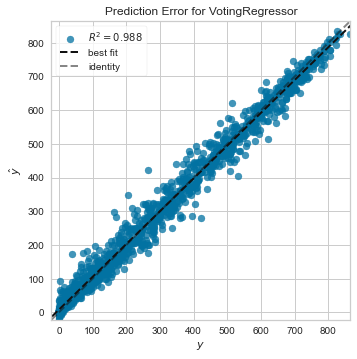

In [32]:
# 회귀 시각화
plot_model(fnlModel, plot='error')


In [26]:
dd = predict_model(fnlModel, data=trainDataL6)

In [27]:
dd

,dtDate,dtDateKst,CA_TOT,HM,PA,TA,TD,WD,WS,PM10,CF,CLD,SWR,pv,sza,aza,et,Label
0,2020-09-01 00:00:00,2020-09-01 00:00:00+09:00,0.009163,88.892297,987.227074,23.486183,21.478494,2.829586,1.139908,5.099294,NaN,NaN,NaN,NaN,135.529429,349.023138,-0.124322,-4.650304
1,2020-09-01 01:00:00,2020-09-01 01:00:00+09:00,5.948927,90.764878,986.960939,23.275037,21.574623,2.340123,1.193194,11.118132,NaN,NaN,NaN,NaN,135.618314,10.291824,-0.111087,2.739254
2,2020-09-01 02:00:00,2020-09-01 02:00:00+09:00,5.183798,93.322567,986.590191,22.487584,21.231781,1.617675,1.021729,14.217076,NaN,NaN,NaN,NaN,131.401487,29.979763,-0.097844,0.071672
3,2020-09-01 03:00:00,2020-09-01 03:00:00+09:00,5.341344,87.416693,985.901259,22.513401,20.214509,10.484047,1.400860,14.731632,NaN,NaN,NaN,NaN,123.859580,46.178586,-0.084592,1.441032
4,2020-09-01 04:00:00,2020-09-01 04:00:00+09:00,5.757849,92.403792,985.555598,21.906141,20.466991,2.912047,0.972121,15.954340,NaN,NaN,NaN,NaN,114.160136,59.066757,-0.071331,1.263397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9092,2021-09-11 20:00:00,2021-09-11 20:00:00+09:00,-0.017783,92.122505,987.442155,21.613608,20.274305,3.376898,0.585084,35.127111,NaN,NaN,NaN,NaN,105.933009,287.549597,3.441922,-8.215730
9093,2021-09-11 21:00:00,2021-09-11 21:00:00+09:00,-0.008410,94.438007,987.769306,20.932248,20.045222,1.976371,0.703916,25.365862,NaN,NaN,NaN,NaN,117.189253,298.171343,3.456582,-5.227140
9094,2021-09-11 22:00:00,2021-09-11 22:00:00+09:00,0.752233,95.914425,988.168906,20.527973,19.872287,1.183558,0.589824,30.186221,NaN,NaN,NaN,NaN,127.242328,311.310923,3.471244,-6.692388
9095,2021-09-11 23:00:00,2021-09-11 23:00:00+09:00,-0.022608,97.435648,988.013266,20.416435,19.933298,1.588771,0.582085,28.654345,NaN,NaN,NaN,NaN,135.168606,328.246481,3.485911,-7.010939


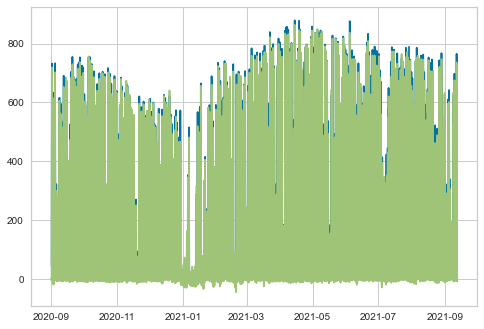

In [29]:
plt.plot(dd['dtDate'], dd['pv'])
plt.plot(dd['dtDate'], dd['Label'])
plt.show()

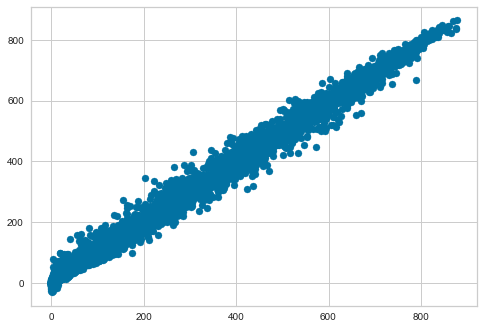

In [22]:
plt.scatter(dd['pv'], dd['Label'])
# plt.plot(test['dtDate'], test['pv'])
# plt.plot(test['dtDate'], test['pv'])
plt.show()


In [1]:

import pandas as pd
from pycaret.datasets import get_data
data = get_data('pycaret_downloads')
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').sum()
data = data.asfreq('D')
data.head()

,Date,Total
0,7/8/2021,3773
1,7/9/2021,3172
2,7/10/2021,2079
3,7/11/2021,2725
4,7/12/2021,4542


,Total
Date,
2021-07-08,3773
2021-07-09,3172
2021-07-10,2079
2021-07-11,2725
2021-07-12,4542


<AxesSubplot:xlabel='Date'>

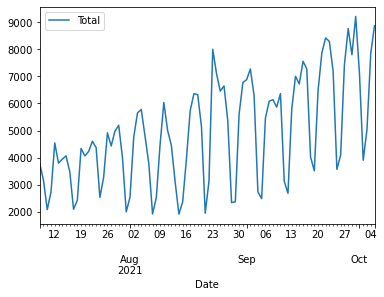

In [2]:
# plot the data
data.plot()

In [23]:
# with functional API
from pycaret.time_series import *
setup(data, fh = 7, fold = 3, session_id = 123)
# with new object-oriented API
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
exp = TimeSeriesExperiment()
exp.setup(data, fh = 7, fold = 3, session_id = 123)


,Description,Value
0,session_id,123
1,Original Data,"(90, 1)"
2,Missing Values,False
3,Transformed Train Set,"(83,)"
4,Transformed Test Set,"(7,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,7
9,Seasonality Detected,True
